[Previous: Preface](00-Preface-to-this-readalong.ipynb)
• [Contents](Contents.ipynb)
• [Next: Time series decomposition](03-Time-series-decomposition.ipynb)

# 2 Time Series Graphics

[FPP3 Chapter 3](https://otexts.com/fpp3/graphics.html)

* [2.1 `DataFrame`s](#2.1-DataFrames)
* [2.2 Time plots](#2.2-Time-plots)
* [2.3 Time series patterns](#2.3-Time-series-patterns)
* [2.4 Seasonal plots](#2.4-Seasonal-plots)
* [2.5 Seasonal subseries plots](#2.5-Seasonal-subseries-plots)
* [2.6 Scatterplots](#2.6-Scatterplots)
* [2.7 Lag plots](#2.7-Lag-plots)
* [2.8 Autocorrelation](#2.8-Autocorrelation)
* [2.9 White noise](#2.9-White-noise)

<hr/>

In [1]:
import sys
sys.path.insert(0, '.')
from utils import *

[utils.py](utils.py)

## 2.1 `DataFrame`s

[FPP3 Section 3.1](https://otexts.com/fpp3/tsibble-objects.html)

We're going to use the `parse_dates` argument quite a bit.  R's `tsibble` seems to do this automagically in many cases.

In [2]:
olympic_running = pd.read_csv('data/tsibbledata/olympic_running.csv', parse_dates=['Year'])
olympic_running

,Year,Length,Sex,Time
0,1896-01-01,100,men,12.00
1,1900-01-01,100,men,11.00
2,1904-01-01,100,men,11.00
3,1908-01-01,100,men,10.80
4,1912-01-01,100,men,10.80
...,...,...,...,...
307,2000-01-01,10000,women,1817.49
308,2004-01-01,10000,women,1824.36
309,2008-01-01,10000,women,1794.66
310,2012-01-01,10000,women,1820.75


In [3]:
PBS = pd.read_csv('data/tsibbledata/PBS.csv', parse_dates=['Month'])
PBS

,Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
0,1991-07-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0
1,1991-08-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0
2,1991-09-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0
3,1991-10-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0
4,1991-11-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0
...,...,...,...,...,...,...,...,...,...
67591,2008-02-01,General,Safety net,Z,NaN,Z,Z,135,1591.0
67592,2008-03-01,General,Safety net,Z,NaN,Z,Z,15,276.0
67593,2008-04-01,General,Safety net,Z,NaN,Z,Z,11,165.0
67594,2008-05-01,General,Safety net,Z,NaN,Z,Z,21,278.0


In [4]:
a10 = (
    PBS
    .query('ATC2 == "A10"')
    .groupby('Month', sort=False)
    .pipe(summarize, lambda x: dict(Cost = x.Cost.sum() / 1e6))
    .reset_index()
    .set_index('Month', drop=False)
)
a10

,Month,Cost
Month,,
1991-07-01,1991-07-01,3.526591
1991-08-01,1991-08-01,3.180891
1991-09-01,1991-09-01,3.252221
1991-10-01,1991-10-01,3.611003
1991-11-01,1991-11-01,3.565869
...,...,...
2008-02-01,2008-02-01,21.654285
2008-03-01,2008-03-01,18.264945
2008-04-01,2008-04-01,23.107677


## 2.2 Time plots

[FPP3 Section 2.2](https://otexts.com/fpp3/time-plots.html)

Some date formats are just harder to parse.

In [5]:
pd.read_csv('data/tsibbledata/ansett.csv').head(3)

,Week,Airports,Class,Passengers
0,1989 W28,ADL-PER,Business,193
1,1989 W29,ADL-PER,Business,254
2,1989 W30,ADL-PER,Business,185


In [6]:
def ansett_parse_week(week):
    y = int(week[:4])
    w = int(week[-2:])
    return pd.to_datetime(y, format='%Y') + pd.to_timedelta(w, 'w')

In [7]:
ansett = pd.read_csv('data/tsibbledata/ansett.csv',
                     parse_dates=['Week'], date_parser=ansett_parse_week)
ansett

,Week,Airports,Class,Passengers
0,1989-07-16,ADL-PER,Business,193
1,1989-07-23,ADL-PER,Business,254
2,1989-07-30,ADL-PER,Business,185
3,1989-08-06,ADL-PER,Business,254
4,1989-08-13,ADL-PER,Business,191
...,...,...,...,...
7402,1992-10-28,SYD-PER,First,203
7403,1992-11-04,SYD-PER,First,137
7404,1992-11-11,SYD-PER,First,161
7405,1992-11-18,SYD-PER,First,155


In [8]:
melsyd_economy = ansett.query("Airports == 'MEL-SYD' and Class == 'Economy'")

In [9]:
melsyd_economy

,Week,Airports,Class,Passengers
3881,1987-07-02,MEL-SYD,Economy,20167
3882,1987-07-09,MEL-SYD,Economy,20161
3883,1987-07-16,MEL-SYD,Economy,19993
3884,1987-07-23,MEL-SYD,Economy,20986
3885,1987-07-30,MEL-SYD,Economy,20497
...,...,...,...,...
4158,1992-10-28,MEL-SYD,Economy,28837
4159,1992-11-04,MEL-SYD,Economy,26548
4160,1992-11-11,MEL-SYD,Economy,27279
4161,1992-11-18,MEL-SYD,Economy,27306


[Pandas](https://pandas.pydata.org/) and [seaborn](https://seaborn.pydata.org/index.html) provide lots of plotting functionality.  I almost always come back to using [matplotlib](https://matplotlib.org/) directly, but here's one example that lets Pandas kick off its own `Axes` instance.

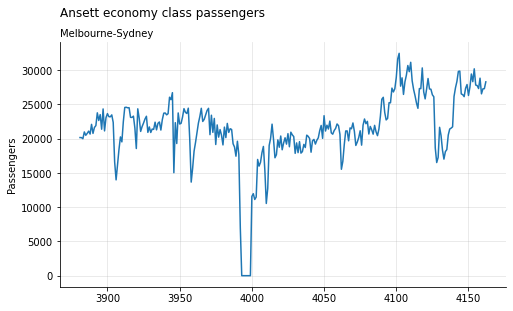

In [10]:
ax = melsyd_economy.Passengers.plot(figsize=sizets)
suptitle('Ansett economy class passengers')
ax.set(ylabel='Passengers', title='Melbourne-Sydney')
ax.grid()

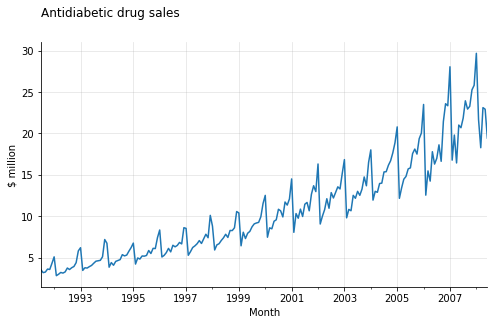

In [11]:
ax = a10.Cost.plot(figsize=sizets)
suptitle('Antidiabetic drug sales')
ax.set(ylabel='$ million')
ax.grid()

## 2.3 Time series patterns

[FPP3 Section 2.3](https://otexts.com/fpp3/tspatterns.html)

## 2.4 Seasonal plots

[FPP3 Section 2.4](https://otexts.com/fpp3/seasonal-plots.html)

I would not be surprised to learn there's an easier way to do this.

In [12]:
def seasonalize(data, column, period='year'):
    if period.lower() in ('year', 'y'):
        d = data.assign(
            __period = data.index.year,
            __x = data.index.dayofyear)
    elif period.lower() in ('week', 'w'):
        d = data.assign(
            __period = 100*data.index.year + data.index.week,
            __x = data.index.dayofweek
                + (data.index.hour + data.index.minute/60 + data.index.second/3600) / 24)
    elif period.lower() in ('day', 'd'):
        d = data.assign(
            __period = data.index.date,
            __x = data.index.hour + data.index.minute/60 + data.index.second/3600)
    d = (
        d
        .sort_values('__x')
        .groupby('__period')
        .pipe(summarize, lambda x: {'time': list(x.__x), column: list(x[column])})
    )
    return d

def plot_seasonal(
        data, column,
        period='year',
        cmap='viridis',
        labels='',
        figsize=None,
        ax=None,
        **kw):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = ax.figure, ax
    d = seasonalize(data, column, period)
    cm = plt.get_cmap(cmap)
    for (i, p) in enumerate(d.index):
        color = cm(i / len(d))
        x, y = d.time.loc[p], d[column].loc[p]
        ax.plot(x, y, color=color, label=str(p), **kw)
        if labels in 'right both'.split():
            ax.text(x[-1], y[-1], str(p), color=color, ha='center', va='center')
        if labels in 'left both'.split():
            ax.text(x[0], y[0], str(p), color=color, ha='center', va='center')
    return ax

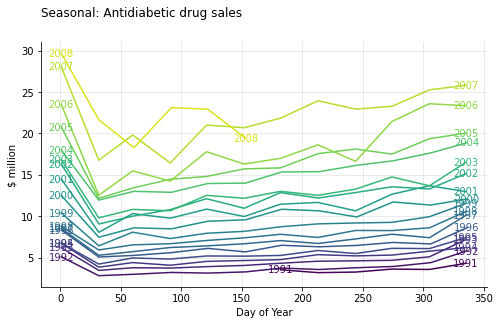

In [13]:
ax = plot_seasonal(a10, 'Cost', labels='both', figsize=sizets)
suptitle('Seasonal: Antidiabetic drug sales')
ax.set(xlabel='Day of Year', ylabel='$ million')
ax.grid()

In [14]:
vic_elec = (
    pd.read_csv('data/tsibbledata/vic_elec.csv')
    .pipe(compute, lambda x: dict(Time = pd.to_datetime(x.Time)))
    .set_index('Time')
)

CPU times: user 581 ms, sys: 10.6 ms, total: 592 ms
Wall time: 591 ms


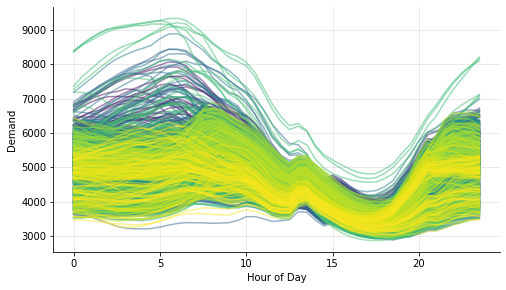

In [15]:
%%time
ax = plot_seasonal(vic_elec, 'Demand', period='d', alpha=.5, figsize=sizets)
ax.set(xlabel='Hour of Day', ylabel='Demand')
ax.grid()

CPU times: user 99.4 ms, sys: 3.23 ms, total: 103 ms
Wall time: 102 ms


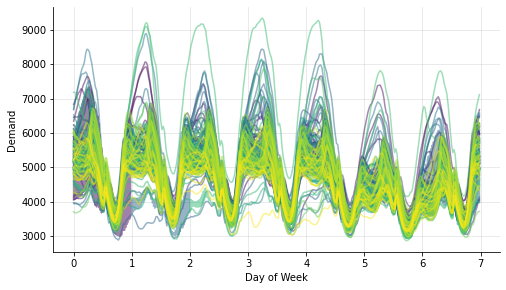

In [16]:
%%time
ax = plot_seasonal(vic_elec, 'Demand', period='w', alpha=.5, figsize=sizets)
ax.set(xlabel='Day of Week', ylabel='Demand')
ax.grid()

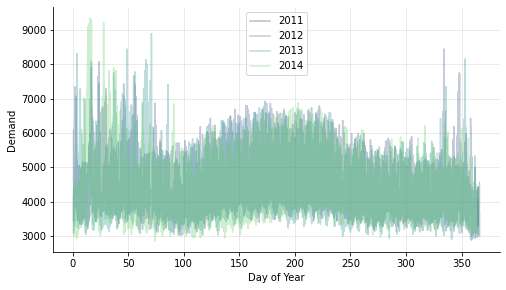

In [17]:
ax = plot_seasonal(vic_elec, 'Demand', period='y', alpha=.3, figsize=sizets)
ax.legend()
ax.set(xlabel='Day of Year', ylabel='Demand')
ax.grid()

## 2.5 Seasonal subseries plots

[FPP3 Section 2.5](https://otexts.com/fpp3/subseries.html)

Somewhat awkwardly with [seaborn FaceGrid()](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html):

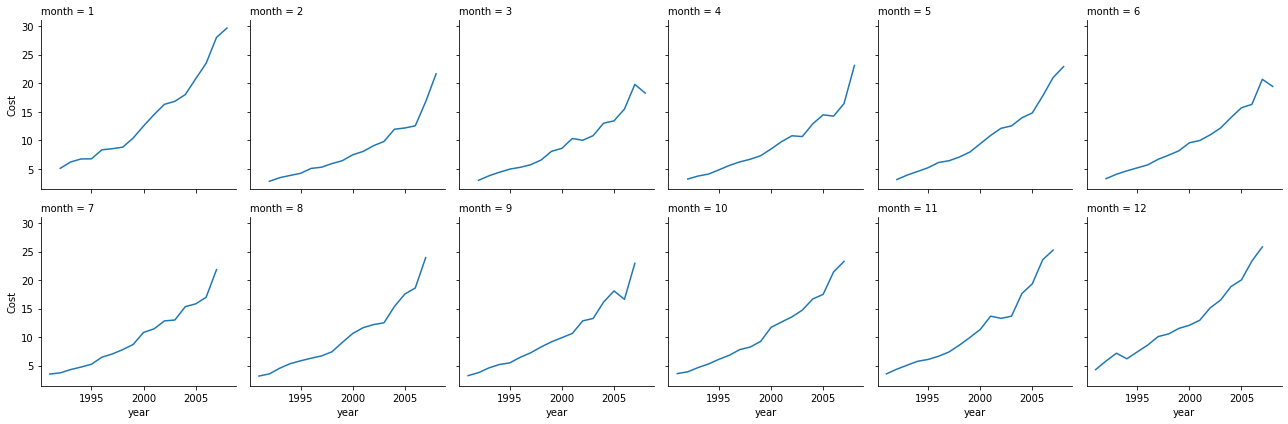

In [18]:
d = a10.assign(year=a10.index.year, month=a10.index.month)
g = sns.FacetGrid(d, col='month', col_wrap=6)
g.map(plt.plot, 'year', 'Cost')

Or, easier with [statsmodels month_plot()](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.month_plot.html):

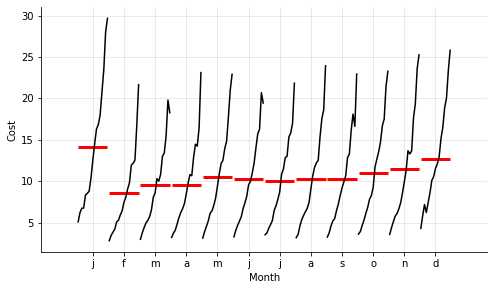

In [19]:
fig, ax = plt.subplots()
sm.graphics.tsa.month_plot(a10.Cost, ax=ax)
ax.set(xlabel='Month', ylabel='Cost')
ax.grid()

This next case is kind of ugly.  The DateTimeIndex is non-unique; it probably should be a [multi-index](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html).

In [20]:
holidays = (
    pd.read_csv('data/tsibble/tourism.csv')
    .pipe(compute, lambda x: dict(
        date=pd.to_datetime(x.Quarter.str.replace(' ', ''))
    ))
    .groupby(['State', 'Quarter', 'date'])
    .pipe(summarize, lambda x: dict(
        Trips=x.Trips.sum(),
    ))
    .reset_index()
    .set_index('date', drop=False)
)
holidays

,State,Quarter,date,Trips
date,,,,
1998-01-01,ACT,1998 Q1,1998-01-01,551.001921
1998-04-01,ACT,1998 Q2,1998-04-01,416.025623
1998-07-01,ACT,1998 Q3,1998-07-01,436.029011
1998-10-01,ACT,1998 Q4,1998-10-01,449.798445
1999-01-01,ACT,1999 Q1,1999-01-01,378.572817
...,...,...,...,...
2016-10-01,Western Australia,2016 Q4,2016-10-01,2656.330701
2017-01-01,Western Australia,2017 Q1,2017-01-01,2570.911689
2017-04-01,Western Australia,2017 Q2,2017-04-01,2438.487939


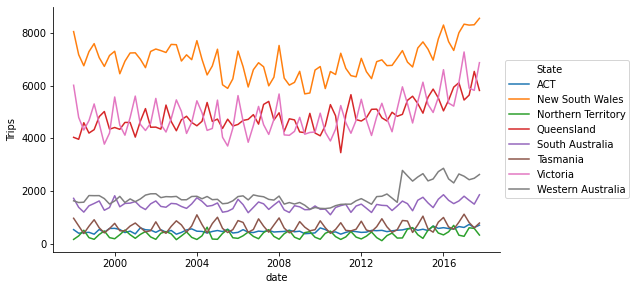

In [21]:
ax = sns.lineplot('date', 'Trips', data=holidays, hue='State')
ax.legend(**legend_right)

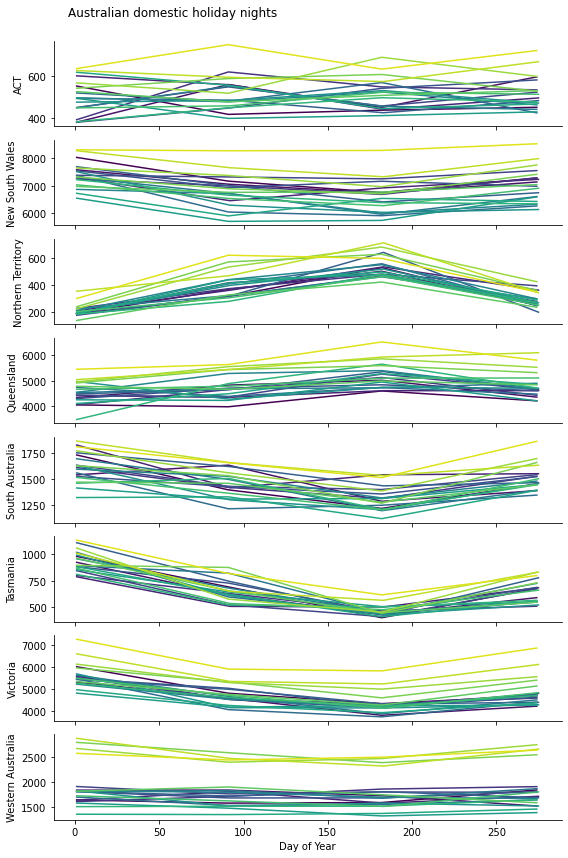

In [22]:
fig, axs = plt.subplots(holidays.State.nunique(), 1, figsize=(8,12), sharex=True)
for (ax, (State, d)) in zip(axs, holidays.groupby('State')):
    plot_seasonal(d.set_index('date'), 'Trips', ax=ax)
    ax.set(ylabel=State)
ax.set(xlabel='Day of Year')
suptitle('Australian domestic holiday nights')
plt.tight_layout()
fig.subplots_adjust(top=.95)

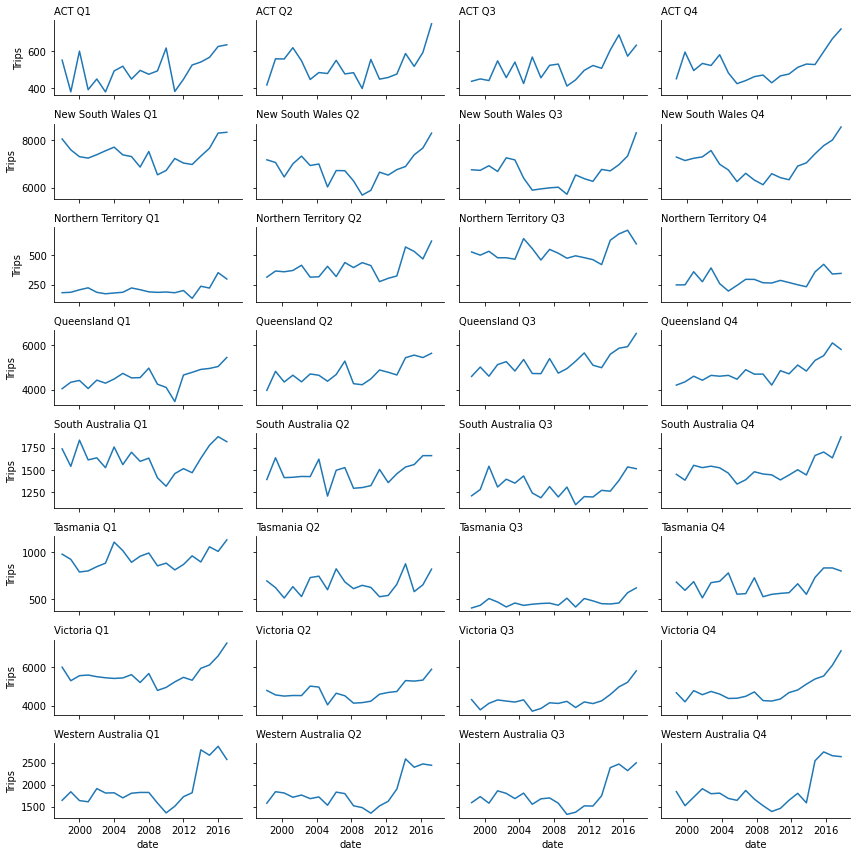

In [23]:
d = holidays.assign(Q = holidays.index.quarter)
g = sns.FacetGrid(d, col='Q', row='State', height=1.5, aspect=2,
                  sharey='row', #margin_titles=True,
                  )
g = g.map(plt.plot, 'date', 'Trips').set_titles('{row_name} Q{col_name}')

## 2.6 Scatterplots

[FPP3 Section 2.6](https://otexts.com/fpp3/scatterplots.html)

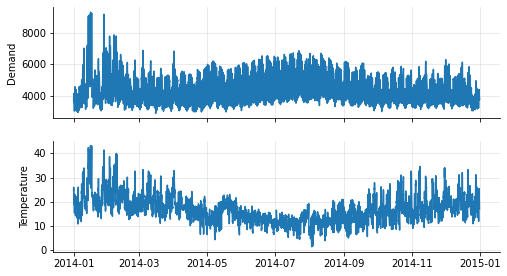

In [24]:
fig, axs = plt.subplots(2, sharex=True)
d = vic_elec[vic_elec.index.year == 2014]
ax = axs[0]
ax.plot(d.Demand)
ax.set(xlabel='', ylabel='Demand')
ax.grid()

ax = axs[1]
ax.plot(d.Temperature)
ax.set(xlabel='', ylabel='Temperature')
ax.grid()

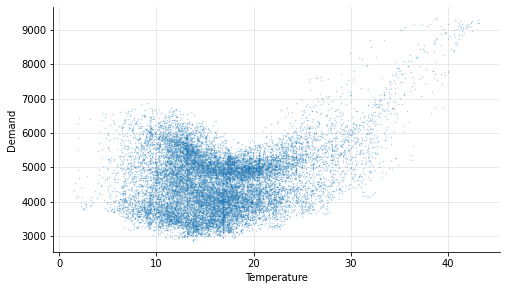

In [25]:
fig, ax = plt.subplots()
ax.plot(d.Temperature, d.Demand, '.', alpha=.33, ms=1)
ax.set(xlabel='Temperature', ylabel='Demand')
ax.grid()

### Pair plots

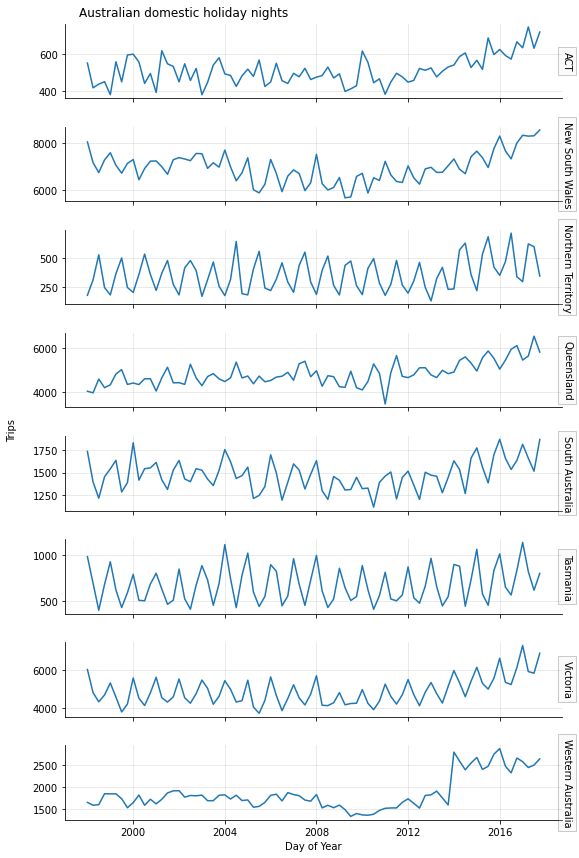

In [26]:
fig, axs = plt.subplots(holidays.State.nunique(), 1, figsize=(8,12), sharex=True)
for (ax, (State, d)) in zip(axs, holidays.groupby('State')):
    ax.plot(d.Trips)
    rlabel(ax, State)
    ax.grid()
ax.set(xlabel='Day of Year')
suptitle('Australian domestic holiday nights')
fig.text(0, .5, 'Trips', rotation=90, va='center')
plt.tight_layout()
fig.subplots_adjust(top=.97, left=.1)

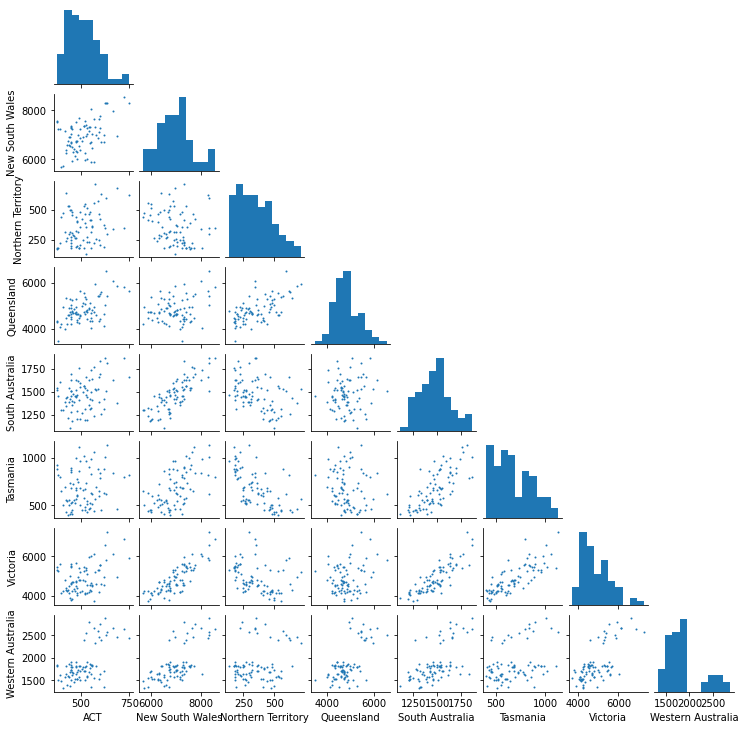

In [27]:
d = holidays.pivot(index='date', columns='State', values='Trips')
sns.pairplot(d, plot_kws=dict(linewidth=0, s=4), corner=True, height=1.25)

## 2.7 Lag plots

[FPP3 Section 2.7](https://otexts.com/fpp3/lag-plots.html)

In [28]:
d = pd.read_csv('data/tsibbledata/aus_production.csv')
recent_production = (
    d
    .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))
    .pipe(compute, lambda x: dict(Year=x.Date.dt.year))
    .query('Year >= 1992')
    .set_index('Date', drop=False)
    .drop(columns='Date Year'.split())
)

recent_production

,Quarter,Beer,Tobacco,Bricks,Cement,Electricity,Gas
Date,,,,,,,
1992-01-01,1992 Q1,443,5777.0,383.0,1289,38332,117
1992-04-01,1992 Q2,410,5853.0,404.0,1501,39774,151
1992-07-01,1992 Q3,420,6416.0,446.0,1539,42246,175
1992-10-01,1992 Q4,532,5825.0,420.0,1568,38498,129
1993-01-01,1993 Q1,433,5724.0,394.0,1450,39460,116
...,...,...,...,...,...,...,...
2009-04-01,2009 Q2,398,NaN,NaN,2160,57471,238
2009-07-01,2009 Q3,419,NaN,NaN,2325,58394,252
2009-10-01,2009 Q4,488,NaN,NaN,2273,57336,210


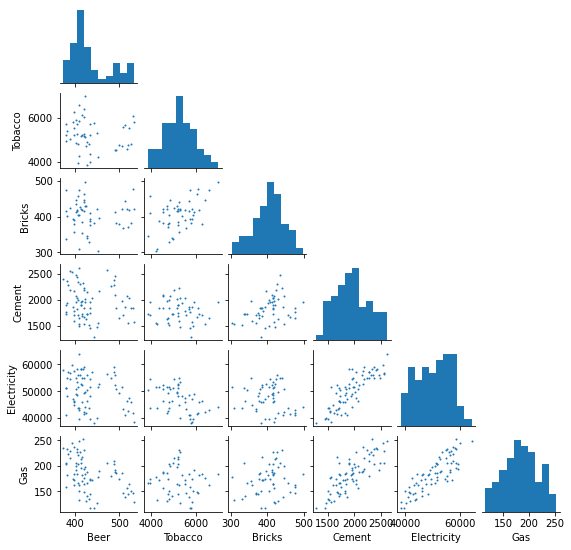

In [29]:
sns.pairplot(recent_production, plot_kws=dict(linewidth=0, s=4), corner=True, height=1.25)

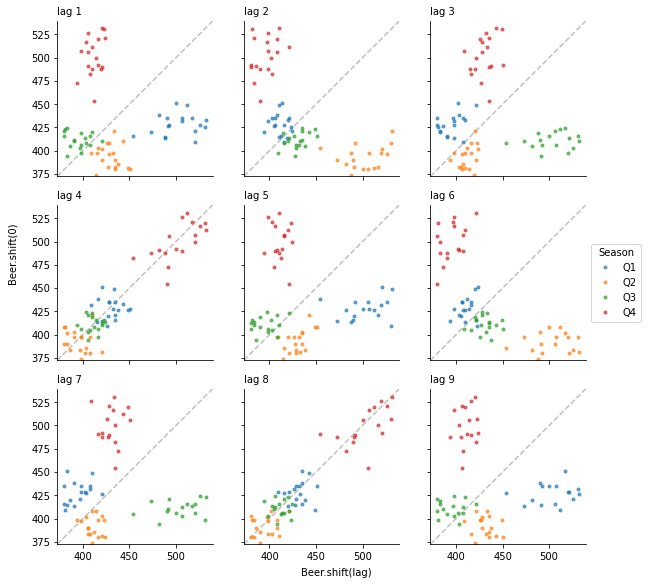

In [30]:
fig, axs = plt.subplots(3, 3, figsize=(9,8), sharex=True, sharey=True)
D = recent_production.copy()
D = pd.DataFrame({lag: D.Beer.shift(lag) for lag in range(10)})
D['q'] = recent_production.index.quarter
for (i, ax) in enumerate(axs.ravel()):
    for (q, d) in D.groupby('q'):
        ax.plot(d[i+1], d[0], '.', alpha=.66, label=f'Q{q}')
        lim = ax.get_xlim()
    ax.plot(lim, lim, 'k--', alpha=.25, zorder=-10)
    ax.set(xlim=lim, ylim=lim, title=f'lag {i+1}', aspect='equal')
axs.ravel()[5].legend(loc='center left', bbox_to_anchor=[1, .5], title='Season')
fig.text(.5, -.01, 'Beer.shift(lag)', ha='center', va='bottom')
fig.text(0, .5, 'Beer.shift(0)', ha='center', va='bottom', rotation=90)
plt.tight_layout()

## 2.8 Autocorrelation

[FPP3 Section 2.8](https://otexts.com/fpp3/acf.html)

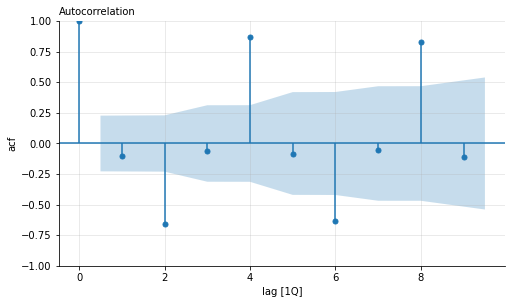

In [31]:
fig, ax = plt.subplots(figsize=sizets)
sm.graphics.tsa.plot_acf(recent_production.Beer, ax=ax, lags=9)
ax.set(ylim=(-1,1), xlabel='lag [1Q]', ylabel='acf')
plt.grid()

### Trend and seasonality in ACF plots

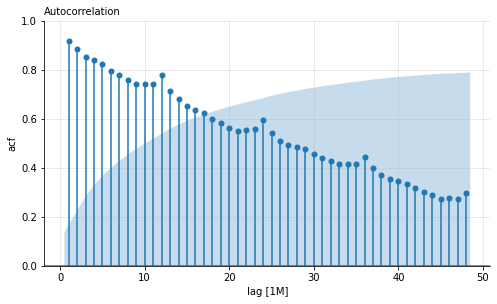

In [32]:
fig, ax = plt.subplots(figsize=sizets)
sm.graphics.tsa.plot_acf(a10.Cost, ax=ax, lags=np.r_[1:48+1])
ax.set(ylim=(0,1), xlabel='lag [1M]', ylabel='acf')
plt.grid()

## 2.9 White noise

[FPP3 Section 2.9](https://otexts.com/fpp3/wn.html)

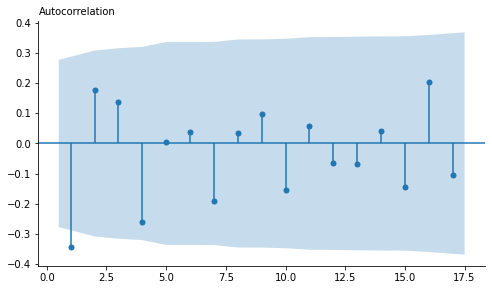

In [33]:
sm.graphics.tsa.plot_acf(np.random.normal(size=50), lags=np.r_[1:18]);

<hr/>

[Previous: Preface](00-Preface-to-this-readalong.ipynb)
• [Contents](Contents.ipynb)
• [Next: Time series decomposition](03-Time-series-decomposition.ipynb)